# Tutorial

The purpose of this notebook is to run through a real-life example of creating individual player point projections for an upcoming week. Let's start by importing the necessary libraries and loading our historical data.

In [30]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.stats import spearmanr
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor, plot_importance

from fantasyfootball.data import FantasyData
from fantasyfootball.features import FantasyFeatures
from fantasyfootball.benchmarking import filter_to_prior_week

In [26]:
# read in data for all positions for 2015 - 2021 seasons
fantasy_data = FantasyData(season_year_start=2015, season_year_end=2022)

Player injury data not available prior to 2016 season


Next, we'll take advantage of a critical feature of the **fantasyfootball** package: custom scoring. I've specified the scoring rules for my league below (hosted on [sleeper](https://sleeper.com/)), which we will use to create our outcome variable. 

In [3]:
scoring_source_name = "sleeper"
custom_scoring_source_rules = {scoring_source_name: {"scoring_columns": {
                    "passing_td": 5,
                    "passing_yds": 0.04,
                    "passing_int": -2,
                    "rushing_td": 6,
                    "rushing_yds": 0.1,
                    "receiving_rec": 1,
                    "receiving_td": 5,
                    "receiving_yds": 0.1,
                    "fumbles_fmb": -2,
                    "scoring_2pm": 4,
                    "punt_returns_td": 6,
                    },
                    "multiplier": {}
                    }}

We'll add our newly created scoring source to the existing scoring sources, which includes Yahoo and Fanduel, and then we will add our outcome variable, `yvar`, to the historical data. 

In [4]:
fantasy_data.add_scoring_source(scoring_source_rules=custom_scoring_source_rules)         
fantasy_data.create_fantasy_points_column(scoring_source=scoring_source_name) 
fantasy_df = fantasy_data.data   
yvar = fantasy_df.columns[-1]

Added scoring source: sleeper


To simulate the conditions of the upcoming week, we'll filter to Week 4 of the 2022 NFL season. The objective is to predict the fantasy points for each player's matchup in Week 5. 

In [34]:
fantasy_df = fantasy_df.filter_to_prior_week(season_year=2022, week_number=4)

The next step is when we'll engineer our features. Let's focus on the wide-receiver position. The first step is removing observations where the player was not active for the game, then eliminating players who played in one or fewer games in a season. 
The rationale for removing inactive players is that zero points are registered to a player when they are inactive, given that they did not play in the game. However, a player may still have values for useful predictors. For example, Fanduel salaries (which correlate strongly with projected points) are created for players throughout the week. If a player is injured and questionable to play, the salary value may remain even after a player is proclaimed inactive. Having a high salary value for a player who scored zero points adds noise to the signal, which can be addressed by simply removing the player from the data we'll train on. 

In [35]:
features = FantasyFeatures(fantasy_df, position="WR", y=yvar)  
features.filter_inactive_games(status_column="is_active")
features.filter_n_games_played_by_season(min_games_played=1)

Once we've cleaned up our data, we build our feature set for the upcoming (unplayed) week. First, we will create placeholders for our features for the upcoming week. Second, we'll add in some of the most potent predictors of future player performance: lags and moving averages. Below we'll make a 4-week moving average based on the number of points scored during the preceding week, the percentage of offensive snaps played, and the number of receiver targets. We'll also create a one week lag on the number of points scored during the previous week, as well as the number of times the player was targeted.

In [36]:
features.create_future_week()
features.add_moving_avg_feature(n_week_window=4, window_columns=[yvar, 'off_snaps_pct','receiving_tgt'])
features.add_lag_feature(n_week_lag=1, lag_columns=[yvar, 'receiving_tgt'])

Finally, we'll finish by creating a "fantasy football signature," which returns a dictionary of our engineered features and their names. 

In [37]:
features_signature_dict = features.create_ff_signature()

Now that we have our newly created features, we'll split our data into historical and future data. Indeed, while calling the `create_future_week` function, an indicator is added to denote historical data, the data we'll use to train our model, future data, or the data we'll use to create our week-player predictions.

In [38]:
feature_df = features_signature_dict.get("feature_df")
hist_df = feature_df[feature_df["is_future_week"] == 0]
future_df = feature_df[feature_df["is_future_week"] == 1]

In addition to our derived features, we'll also include several untransformed, raw features that could help us predict how many points a player will score in the upcoming week, including: 

* `avg_draft_position` - Think of this feature as a "prior." A draft position can be a helpful predictor when it's early in the season, and we don't have a lot of data. However, as the season progresses and we update our prior with new information (e.g., how many points a player has scored in the first four weeks), it becomes less valuable. 

* `projected_off_pts` - Games with high point projections should yield more fantasy points relative to those with lower projections. 

* `fanduel_salary` - The higher the salary, the more points a player is expected to score. Salaries are published each week during a season. 

* `receiving_def_rank` - The higher the rank, the more receiving yards and touchdowns a player is expected to score.

We'll specify all of these below to create our full feature set. 

In [39]:
derived_feature_names = features_signature_dict.get("pipeline_feature_names")
raw_feature_names = [
    "avg_draft_position",
    "projected_off_pts",
    "fanduel_salary",
    "receiving_def_rank",
]
all_features = derived_feature_names + raw_feature_names 

### Feature Selection & Hyperparameter Tuning

Before making our weekly predictions, we'll do feature selection and hyperparameter optimization. I won't spend too much time on this section, given that the focus here is on the package itself. However, the goal is to (1) select only the most predictive features and (2) select the best combination of hyperparameters for a given feature set. 

In [40]:
X = hist_df[all_features]
X = X.apply(pd.to_numeric, errors='coerce')
y = hist_df[yvar]

In [41]:
objective = "reg:squarederror"
eval_metric = "rmse"
param_grid = {
    "max_depth": [3, 4],
    "learning_rate": [0.01, 0.05],
    "n_estimators": [100, 500],
}
n_folds = 5
perf_df = pd.DataFrame()
n_features = range(1, len(all_features) + 1)
for n_feature in n_features:
    xgb = XGBRegressor(objective=objective, eval_metric=eval_metric)
    rfe = RFE(estimator=xgb, n_features_to_select=n_feature)
    rfe.fit(X, y)
    # extract indexes of selected features
    selected_features = X.columns[rfe.support_]
    # create grid
    grid_search = GridSearchCV(
        XGBRegressor(objective=objective, eval_metric=eval_metric),
        param_grid,
        verbose=1,
        n_jobs=-1,
        cv=n_folds,
    )
    # fit the model
    grid_search.fit(X[selected_features], y)
    # extract cv performance
    cv_results_df = pd.DataFrame(grid_search.cv_results_).query("rank_test_score == 1")
    # add the features that were selected
    cv_results_df["features"] = selected_features = ", ".join(
        selected_features.tolist()
    )
    cv_results_df["n_features"] = n_feature
    cv_results_df = cv_results_df[
        [
            "features",
            "n_features",
            "param_learning_rate",
            "param_max_depth",
            "param_n_estimators",
            "mean_test_score",
            "std_test_score",
        ]
    ]
    perf_df = pd.concat([perf_df, cv_results_df])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


Now that we have results, we'll filter only to those combinations (features + hyperparameters) that fall within one standard deviation of the best combination. Then, we'll select the simplest model (i.e., the model with the fewest features) that falls within the range. 

In [42]:
# find the best mean_test_score
best_mean_test_score = perf_df["mean_test_score"].max()
# find the stardard deviation of the best mean_test_score
best_std_test_score = perf_df.query("mean_test_score == @best_mean_test_score")[
    "std_test_score"
].values[0]
# create the threshold to filter the best models
threshold = best_mean_test_score - best_std_test_score
# find simplest solution that is within 1 standard deviation of the best mean_test_score
perf_df = perf_df[perf_df["mean_test_score"] > threshold].sort_values("mean_test_score")
perf_df = perf_df.reset_index().drop("index", axis=1).round(3)

In [43]:
perf_df

,features,n_features,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,std_test_score
0,"off_snaps_pct_ma_4, fanduel_salary",2,0.01,3,500,0.378,0.024
1,"off_snaps_pct_ma_4, receiving_tgt_ma_4, fandue...",3,0.05,3,100,0.382,0.025
2,"off_snaps_pct_ma_4, receiving_tgt_ma_4, avg_dr...",4,0.01,4,500,0.384,0.026
3,"off_snaps_pct_ma_4, receiving_tgt_ma_4, ff_pts...",6,0.05,4,100,0.385,0.023
4,"ff_pts_sleeper_ma_4, off_snaps_pct_ma_4, recei...",8,0.01,3,500,0.385,0.026
5,"off_snaps_pct_ma_4, receiving_tgt_ma_4, ff_pts...",5,0.01,3,500,0.385,0.024
6,"ff_pts_sleeper_ma_4, off_snaps_pct_ma_4, recei...",7,0.05,3,100,0.386,0.025
7,"ff_pts_sleeper_ma_4, off_snaps_pct_ma_4, recei...",9,0.05,3,100,0.386,0.025


Based on these results, the model we'll use go-forward has the following characteristics: 

* Two Features - fanduel salary and the average percent of offensive snaps played over the past four weeks
* A learning rate of 0.01 (or how much weight we put on new trees that are added to the model)
* A maximum depth of 3 (or the maximum number of splits in a tree)
* N estimators of 500 (or the number of trees in the ensemble)

Note that these results make intuitive sense: The Fanduel salary likes combines many of the features we've already engineered (e.g., the number of targets, the number of offensive snaps played, and the number of points scored in the previous week), as it directly measures the number of points a player is expected to score. 

In [44]:
final_features = perf_df["features"].values[0].split(", ")
final_hyperparams = (
    perf_df[["param_learning_rate", "param_max_depth", "param_n_estimators"]]
    .values[0]
    .tolist()
)

To further support the notion that we've selected relevant features, I like to plot feature importance against a "noise" variable or something we know has no relationship with the outcome variable. 

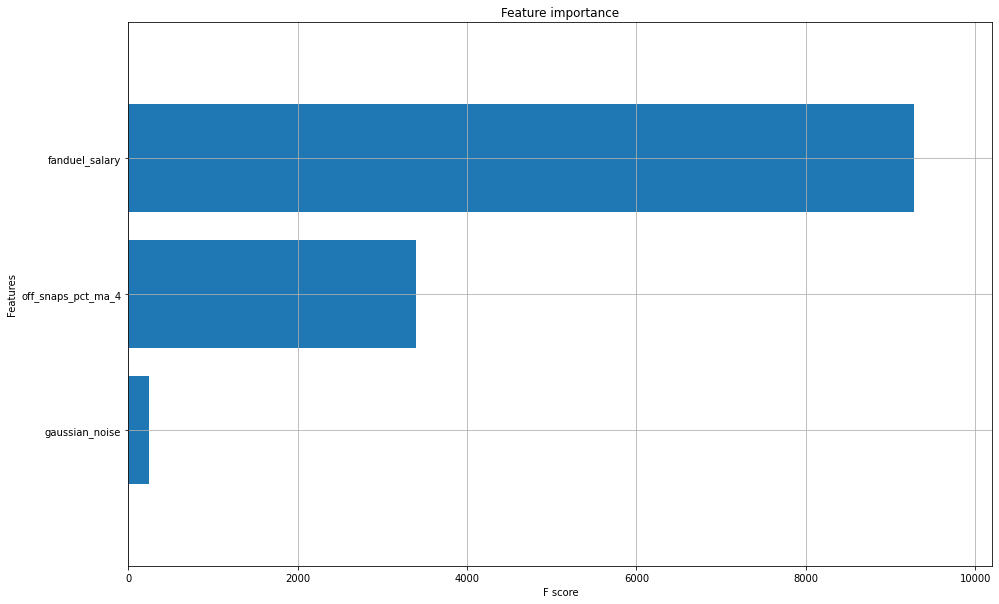

In [50]:
# create gaussian noise
gaussian_noise = np.random.normal(0, 0.1, size=len(X))
X["gaussian_noise"] = gaussian_noise
# get feature importance from xgboost
xgb = XGBRegressor(
    objective=objective,
    eval_metric=eval_metric,
    learning_rate=final_hyperparams[0],
    max_depth=final_hyperparams[1],
    n_estimators=final_hyperparams[2],
)
xgb.fit(X[final_features + ["gaussian_noise"]], y)
# plot feature importance
imp_plt = plot_importance(xgb, height=0.8, importance_type="gain", show_values=False)
# center the plot
imp_plt.figure.subplots_adjust(left=0.3)
# increase size of plot
imp_plt.figure.set_size_inches(20, 10)

The last step here is to filter our historical and future dataframes to our two features, re-fit our model, and then make predictions on our yet-to-be-played week 

In [16]:
%%capture
X_hist, y_hist = (
    hist_df[final_features + [yvar]]
    .apply(pd.to_numeric, errors="coerce")
    .get_features_targets(yvar, final_features)
)
xgb.fit(X_hist, y_hist)

### Inference Results

Now that we have our predictions, we can compare them to a baseline prediction. In this case, we'll use the player weekly rankings from Sports Illustrated. 

In [17]:
X_future = future_df[final_features].apply(pd.to_numeric, errors='coerce')
y_pred = xgb.predict(X_future)
future_df = future_df[['name', 'pid'] + final_features]
future_df = future_df.assign(**{f"{yvar}_pred": y_pred})
future_df = future_df.sort_values(by=f"{yvar}_pred", ascending=False)
future_df[f"{yvar}_pred_rank"] = future_df[f"{yvar}_pred"].rank(ascending=False)

In [18]:
# read in sports illustrated week 5 wr rankings
fname = "2022-week-5-wr-rankings.csv"
github_url = "https://raw.githubusercontent.com/thecodeforest/fantasyfootball/inference-example/examples/inference_data"
wk5_wr_rankings_df = pd.read_csv(f"{github_url}/{fname}")

In [19]:
wk5_wr_rankings_df.head()

,name,team,si_rank
0,Cooper Kupp,LAR,1
1,Stefon Diggs,BUF,2
2,Justin Jefferson,MIN,3
3,Tyreek Hill,MIA,4
4,Davante Adams,LV,5


Let's bring both of our datasets together below. 

In [20]:
rankings_df = pd.merge(future_df, wk5_wr_rankings_df, on="name", how="inner")
rankings_df = rankings_df.drop(columns="team")
# examine the top 40 players
rankings_df = rankings_df.head(40).round(0)

The first step is to consider the correlation between the rankings of Fantasy Football and Sports Illustrated (SI). We'll use the Spearman correlation, as it measures the strength of a monotonic relationship between two ordinal variables.

In [21]:
spearmen_r, p_value = spearmanr(rankings_df[f"{yvar}_pred_rank"], rankings_df["si_rank"])
print(f"Spearman's R: {round(spearmen_r, 2)} - p-value: {round(p_value, 2)}")

Spearman's R: 0.87 - p-value: 0.0


Finally, we'll plot the top 40 players from the Fantasy Football package relative to the top players from SI.

In [22]:
fig = px.scatter(rankings_df, x=f"{yvar}_pred_rank", y="si_rank", hover_name="name")
fig.update_layout(
    title="2022 Week 5 WR Rankings",
    xaxis_title="Fantasy Football Rank",
    yaxis_title="Sports Illustrated Rank",
    font=dict(family="Courier New, monospace", size=12, color="black"),
)
fig.update_layout(
    autosize=True,
    width=1000,
    height=600,
)
fig.add_shape(type="line", x0=0, y0=0, x1=50, y1=50, line=dict(color="Red", width=2))
for i, row in rankings_df.iterrows():
    x_offset = 0.1
    y_offset = 0.5
    fig.add_annotation(
        x=row[f"{yvar}_pred_rank"] + x_offset,
        y=row["si_rank"] + y_offset,
        text=row["name"],
        showarrow=False,
    )

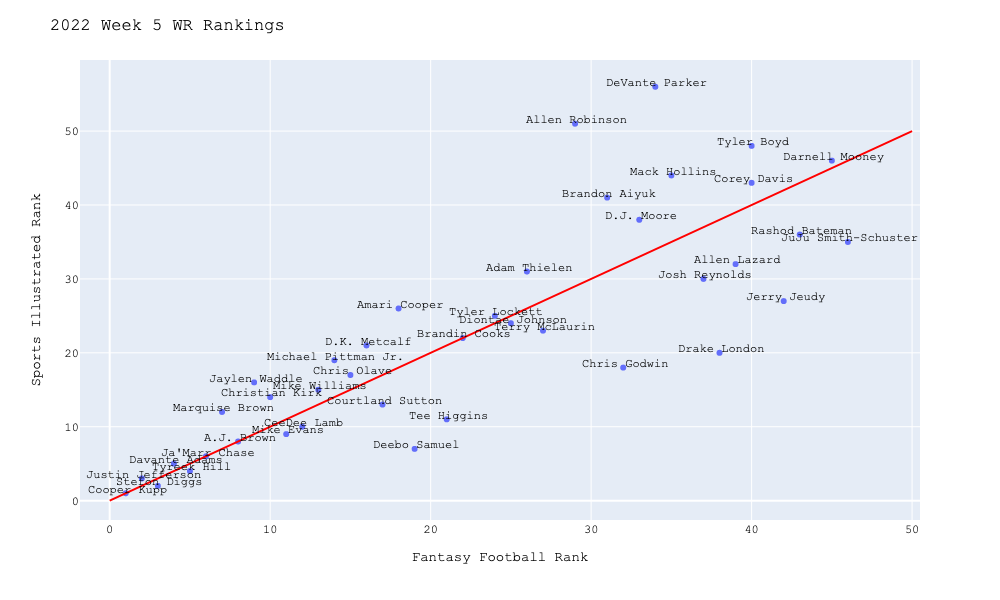

In [23]:
fig.show("png")

It's encouraging to see that the Fantasy Fooball rankings track closely to the SI rankings. However, there are some notable differences. For example, the Fantasy Football package ranks the following players higher than SI:
* Amari Cooper
* Allen Robinson
* Devante Parker

While SI ranks the following players higher than Fantasy Football:
* Deebo Samuel
* Chris Godwin
* Drake London

We'll have to wait and see how these players perform in the upcoming week to see who was right! Stay tuned for more!